In [48]:
import pony.orm as porm
import database as db
import pandas as pd
from datetime import date
import station_names
import getpass
import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
import time
import warnings
from calendar import monthrange

In [2]:
db.set_up_connection(db.db, 'db_weather', user ='webscrapers', password='bCCnw3b') #bCCnw3b

In [19]:
#query = db.HourlyPrediction.select(lambda m : m.city== 'BERLIN' and m.date_for_which_weather_is_predicted=='2018-06-09').get_sql()
inputlist = ["BERLIN", '2018-06-29 13:00:00']

query = db.HourlyPrediction.select(lambda m : m.city== inputlist[0] and m.date_for_which_weather_is_predicted == inputlist[1])

In [21]:
inputdict = {'city' : '"BERLIN"','date_for_which_weather_is_predicted' : '"2018-06-29 13:00:00"'}

querystring_list = ['m.{}=={}'.format(key, val) for key,val in inputdict.items()]

querystring = 'lambda m: ' + querystring_list[0]
if len(inputdict)>1:
    for i in range(1,len(inputdict)):
        querystring += ' and '+querystring_list[i]

print(querystring)

lambda m: m.city=="BERLIN" and m.date_for_which_weather_is_predicted=="2018-06-29 13:00:00"


In [34]:
data=db.query_to_dataframe(db.DailyPrediction.select(querystring))
data

,id,website,city,date_of_acquisition,date_for_which_weather_is_predicted,temperature_max,temperature_min,wind_speed,humidity,precipitation_per,precipitation_l,wind_direction,condition,snow,uvi
0,113,The Weather Channel,BERLIN,2018-06-27,2018-06-29,28.0,12.0,19.0,46.0,0.0,None,NNW,Clear,0.0,None
1,163,The Weather Channel,BERLIN,2018-06-27,2018-06-29,29.0,12.0,21.0,46.0,0.0,None,NNW,Clear,0.0,None
2,213,The Weather Channel,BERLIN,2018-06-27,2018-06-29,29.0,12.0,21.0,46.0,0.0,None,NNW,Clear,0.0,None
3,283,The Weather Channel,BERLIN,2018-06-27,2018-06-29,29.0,12.0,21.0,45.0,0.0,None,NNW,Clear,0.0,None
4,482,The Weather Channel,BERLIN,2018-06-28,2018-06-29,29.0,12.0,21.0,44.0,0.0,None,N,Clear,0.0,None
5,681,The Weather Channel,BERLIN,2018-06-29,2018-06-29,29.0,12.0,23.0,42.0,0.0,None,NNW,Clear,0.0,None


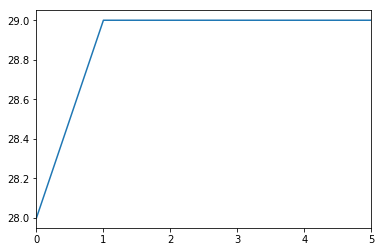

In [29]:
data.temperature_max.plot()

In [57]:
#input options
#list of columns we want to plot
#city and dates need to be specified, also columns of data to be returned

def convert_label(label):  
    if label not in ld.ld_dwd:
        warnings.warn('Your label was not valid and will not be plotted! If you are unsure please have a look in label_dict.py or call show_all_labels()')
        return None
    else:
        return ld.ld_dwd[label]

def show_all_labels():
    '''
        Prints all possibles labels that can be queried from the dwd data base.
    '''
    print(list(ld.ld_dwd.keys()))
    
def query_for_plot_predict(time_start, time_end, labels, cities):
    
    '''
        Parameters:
            time_start = a string giving the beginning of the interval to plot, can be a year (YYYY), 
                         year and month (YYYYMM) or year, month and day (YYYYMMDD) (later on also: or with hour (YYYYMMDDHH))
            time_end = a string giving the end of the interval to 
            labels = The feature you want to plot e.g mean temperature, can be list or scalar. For all possible labels please see label_dict.py or call show_all_labels()
            cities = for which city you want to plot the feature, can be list or scalar
            NOTE: just cities OR labels can be a list, the other one need to be a single value (for now)
        Returns:
            name = title of the plot
            dataframe = pandas dataframe with rows beeing the time (all timestaps can be found in a column called 'dates') 
                        and row corresoning to the freatures asked for (if both, cities and labels are single values, 
                        than the key will be the label, otherwise it will be the items in the list argument)
    '''
    # create dytime interval
    t_ival=[time_start, time_end]

    # make sure that the start time is before the end time, if not switch it
    n_days = (t_ival[1]-t_ival[0]).days
    if n_days < 0:
        t_ival = t_ival[::-1]
        n_days = abs(n_days)

    # dict which will be converted to the dataframe later on
    data = {}

    #if one city and multiple labels are queried
    if np.isscalar(cities) and not np.isscalar(labels):
        # search for the dwd labels in respective dict
        dwd_labels = [labels]
        if len(dwd_labels) != len(labels):
            warnings.warn('Some of your labels were not valid and will not be plotted! If you are unsure please have a look in label_dict.py or call show_all_labels()')
        # make a query to the data base
        query = db.DailyPrediction.select(lambda m : cities in m.city and str(t_ival[0]) <= m.date_for_which_weather_is_predicted \
                                          and m.date_for_which_weather_is_predicted <= str(t_ival[1]))
        pd_query = db.query_to_dataframe(query)
        # mean over all station with the respective city in the name
        means_db = pd_query.sort_values('date_for_which_weather_is_predicted').groupby('date_for_which_weather_is_predicted').mean()
        # get all queried labels
        for li, label in enumerate(dwd_labels):
            data[label] = list(means_db[label])
        data['dates'] = list(means_db[label].keys())
    # if it is asked for multiple cities and just one label
    elif np.isscalar(labels) and not np.isscalar(cities):
        # search for the dwd labels in respective dict
        for ci, city in enumerate(cities):
            # make a query to the data base for each city
            query = db.DailyPrediction.select(lambda m : cities in m.city and str(t_ival[0]) <= m.date_for_which_weather_is_predicted \
                                          and m.date_for_which_weather_is_predicted <= str(t_ival[1]))
            pd_query = db.query_to_dataframe(query)
            # mean over all station with the respective city in the name
            means_db = pd_query.sort_values('date_for_which_weather_is_predicted').groupby('date_for_which_weather_is_predicted').mean()
            # get the queried label
            data[city] = list(means_db[labels])
        data['dates'] = list(means_db[labels].keys())
    # if it is asked for just oen city and one label
    else:
        # make a query to the data base for each city
        query = db.DailyPrediction.select(lambda m : cities in m.city and str(t_ival[0]) <= m.date_for_which_weather_is_predicted \
                                          and m.date_for_which_weather_is_predicted <= str(t_ival[1]))
        pd_query =  db.query_to_dataframe(query)
        # mean over all station with the respective city in the name
        means_pd = pd_query.sort_values('date_for_which_weather_is_predicted').groupby('date_for_which_weather_is_predicted').mean()
        data['dates'] = list(means_pd[labels].keys())
        # get the queried label
        data[labels] = list(means_pd[labels])

    # create data frame where the date is now a normal column
    data_frame = pd.DataFrame(data=data) 
    return data_frame
    

In [58]:
cities = 'BERLIN'
labels = 'temperature_max'
time_start = date(2018,6,26)
time_end = date(2018,6,27)

query_for_plot_predict(time_start, time_end, labels, cities)

,dates,temperature_max
0,2018-06-27,24.0
